# Stroke Prediction Dataset

## Overview

This dataset is designed for predicting the likelihood of stroke occurrence in individuals based on several health indicators and demographic factors. It combines medical data like glucose level and BMI with personal attributes such as age, marital status, work type, and smoking habits. The data can be useful for building predictive models to support early intervention and stroke prevention in healthcare settings.

## Column Descriptions
| Column              | Type      | Description                                                                 |
|---------------------|-----------|-----------------------------------------------------------------------------|
| id                  | Integer   | Unique identifier for each record.                                          |
| gender              | Object    | Gender of the patient: "Male", "Female", or "Other".                        |
| age                 | Float     | Age of the patient in years.                                                |
| hypertension        | Integer   | Whether the patient has hypertension (0 = No, 1 = Yes).                     |
| heart_disease       | Integer   | Whether the patient has any heart diseases (0 = No, 1 = Yes).               |
| ever_married        | Object    | Whether the patient was ever married ("Yes" or "No").                       |
| work_type           | Object    | Type of work: "Private", "Self-employed", "Govt_job", "children", etc.      |
| Residence_type      | Object    | Type of residence: "Urban" or "Rural".                                      |
| avg_glucose_level   | Float     | Average glucose level in blood.                                             |
| bmi                 | Float     | Body Mass Index. (201 missing values present)                               |
| smoking_status      | Object    | Smoking status: "formerly smoked", "never smoked", "smokes", "Unknown".     |
| stroke              | Integer   | Target variable: whether the patient had a stroke (0 = No, 1 = Yes).        |

# Libraries Used in Stroke Prediction Project

- sqlalchemy: Used to create a connection to a database.
- quote_plus: Encodes special characters in database URLs.
- pandas: For loading and handling tabular data.
- MinMaxScaler: Scales features to a 0–1 range.
- StandardScaler: Standardizes data to have mean = 0 and std = 1.
- skew: Measures the asymmetry of a data distribution.
- train_test_split: Splits the data into training and testing sets.
- SMOTE: Balances imbalanced datasets by generating synthetic samples.
- Counter: Counts elements, useful for class distribution.
- LogisticRegression: A linear model for binary classification.
- classification_report: Displays precision, recall, and F1-score.
- accuracy_score: Calculates the overall accuracy of predictions.
- RandomForestClassifier: An ensemble model using multiple decision trees.
- f1_score: Combines precision and recall into a single metric.
- precision_score: Measures how many predicted positives are correct.
- recall_score: Measures how many actual positives are correctly predicted.
- xgboost: An optimized gradient boosting library for high performance.
- seaborn: For creating beautiful statistical visualizations.
- matplotlib.pyplot: For basic plotting and graphs.

In [4]:
from sqlalchemy import create_engine
from urllib.parse import quote_plus
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
import xgboost as xgb

## 1.1 Data Pipeline

- The dataset is first imported into a relational database (e.g., PostgreSQL).
- Python's SQLAlchemy is used to establish a connection and load the data into a pandas DataFrame for processing.

In [6]:
db_user = 'postgres'
db_password = quote_plus('root') 
db_host = 'localhost'
db_port = '5432'
db_name = 'stroke_data'

engine = create_engine(f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')

# df = pd.read_csv("C:/Users/Dell/OneDrive/Desktop/healthcare-dataset-stroke-data.csv")
# df.to_sql('stroke_raw', engine, if_exists='replace', index=False)

df = pd.read_sql('stroke_raw', engine)
print("Data uploaded to PostgreSQL successfully!")

Data uploaded to PostgreSQL successfully!


## 1.2 Cleaned Dataset

The data is cleaned and prepared by:

- Handling Missing Values: Fill missing entries to ensure model reliability.
- Converting Data Types: Cast columns to appropriate types (categorical).
- Outlier Removal: Identify and remove data points that fall outside a normal range.

The cleaned dataset is saved as a .csv file.

## 1.3 Dataset Exploration

Initial exploration includes:

- Schema Analysis: Understand the structure and types of features.
- Summary Statistics: View measures like mean, median, std, etc.
- Anomaly Detection: Identify duplicates.
- Insights: Highlight key trends or data quality concerns.

## 1.4 Basic EDA (Exploratory Data Analysis)

- Univariate Visualizations: Histograms, box plots, and bar charts for individual variables.
- Distribution Analysis: Understand how values are spread across each feature.
- Category Balance: Examine class imbalance in categorical features (e.g., stroke outcome).
- Grouped Statistics: Compare variables across different categories (e.g., stroke vs no stroke).

In [8]:
print(df.head())

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  


In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None


In [10]:
print(df.isnull().sum())

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [11]:
df['bmi'] = df['bmi'].fillna(df['bmi'].mean())
print(df.isnull().sum())

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


In [12]:
print(df.dtypes)

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object


In [13]:
df['gender'] = df['gender'].astype('category')
df['smoking_status'] = df['smoking_status'].astype('category')

In [14]:
print(df.dtypes)

id                      int64
gender               category
age                   float64
hypertension            int64
heart_disease           int64
ever_married           object
work_type              object
Residence_type         object
avg_glucose_level     float64
bmi                   float64
smoking_status       category
stroke                  int64
dtype: object


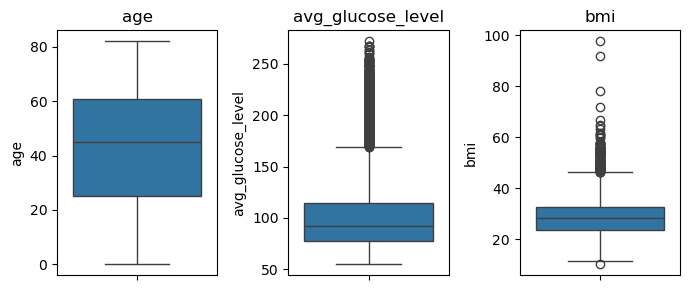

In [15]:
numerical_cols = ['age', 'avg_glucose_level', 'bmi']

fig, axes = plt.subplots(1, 3, figsize=(7, 3))  

for i, col in enumerate(numerical_cols):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(f'{col}')

plt.tight_layout()
plt.show()

In [16]:
outlier_cols = ['avg_glucose_level', 'bmi']

for col in outlier_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_clean = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

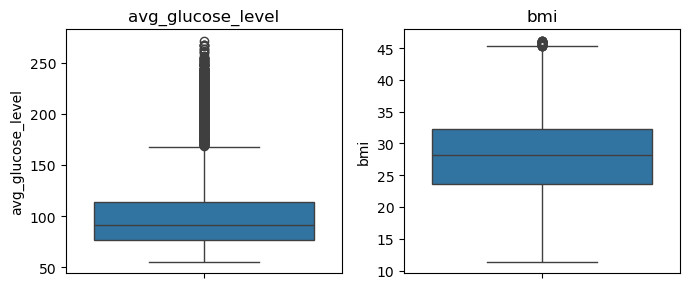

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))  
for i, col in enumerate(outlier_cols):
    sns.boxplot(y=df_clean[col], ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

In [18]:
df_clean.to_csv(r"D:\Khaled\Yassmin DEPI Final project\data\healthcare-dataset-stroke-data-cleaned.csv", index=False)
print("data stored.")

data stored.


In [19]:
print(df_clean.describe())

                 id          age  hypertension  heart_disease  \
count   4984.000000  4984.000000   4984.000000    4984.000000   
mean   36606.633828    43.204807      0.095706       0.055177   
std    21150.796028    22.787251      0.294218       0.228347   
min       67.000000     0.080000      0.000000       0.000000   
25%    17807.500000    25.000000      0.000000       0.000000   
50%    36964.500000    45.000000      0.000000       0.000000   
75%    54805.500000    61.000000      0.000000       0.000000   
max    72940.000000    82.000000      1.000000       1.000000   

       avg_glucose_level          bmi       stroke  
count        4984.000000  4984.000000  4984.000000  
mean          105.730688    28.284438     0.049358  
std            44.828533     6.630594     0.216636  
min            55.120000    11.300000     0.000000  
25%            77.197500    23.600000     0.000000  
50%            91.835000    28.200000     0.000000  
75%           113.755000    32.300000     0

In [20]:
print(df_clean.duplicated().sum())

0


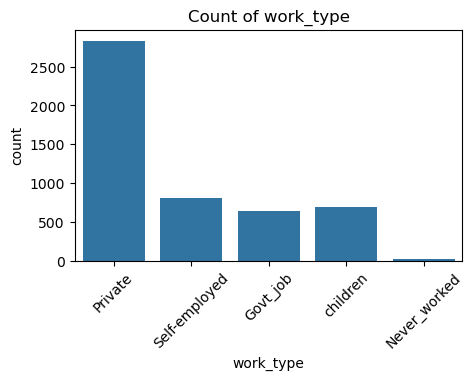

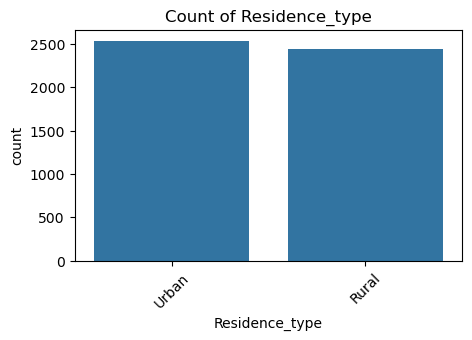

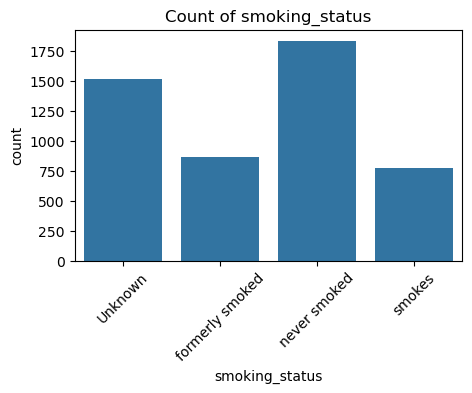

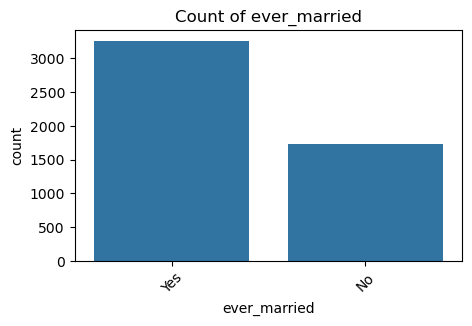

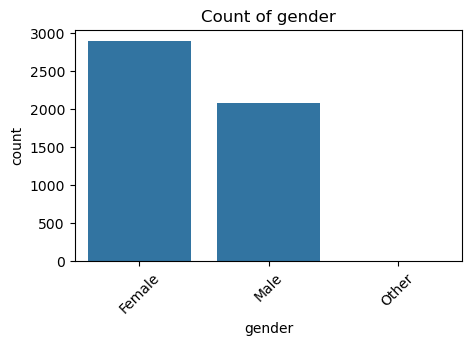

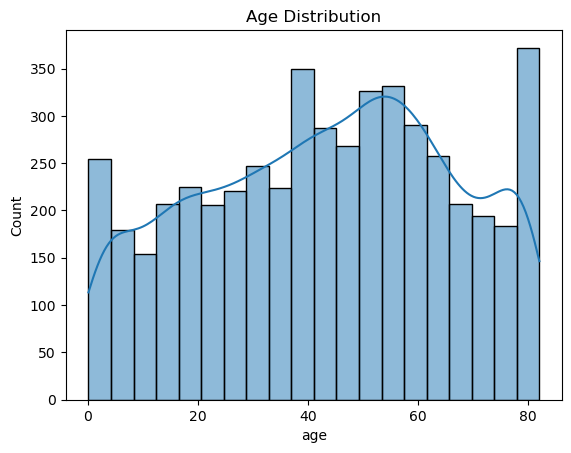

In [21]:
count_cols = ['work_type', 'Residence_type', 'smoking_status','ever_married','gender']

for col in count_cols:
    plt.figure(figsize=(5, 3))
    sns.countplot(x=df_clean[col])
    plt.title(f'Count of {col}')
    plt.xticks(rotation=45)
    plt.show()
    
sns.histplot(df_clean['age'], bins=20, kde=True)
plt.title("Age Distribution")
plt.show()

# Stroke Data - Exploratory Questions & Visual Insights

This section summarizes key questions answered during exploratory data analysis (EDA), with brief insights based on the results.

---

### 1. Stroke Distribution by Residence Type  
Stroke cases were compared between urban and rural residents. The goal was to observe if living environment influences stroke occurrence.

---

### 2. Stroke and Hypertension  
We examined whether individuals with hypertension are more likely to suffer from strokes. The results suggested a higher stroke rate among hypertensive patients.

---

### 3. Stroke by Work Type  
The dataset was analyzed to compare stroke rates across various work types. This helps identify if certain professions may have higher stroke risks.

---

### 4. Stroke Rate Across Age Groups  
Age was grouped into ranges to observe stroke trends. The analysis showed stroke risk significantly increases with age, especially after age 60.

---

### 5. Heart Disease and Stroke Relationship  
Individuals with heart disease were more likely to experience strokes. This confirms heart disease as an important contributing factor.

---

### 6. Smoking Status and Stroke  
We explored the relationship between smoking behavior (never, former, current) and stroke. Results suggest smoking may be associated with higher stroke risk.

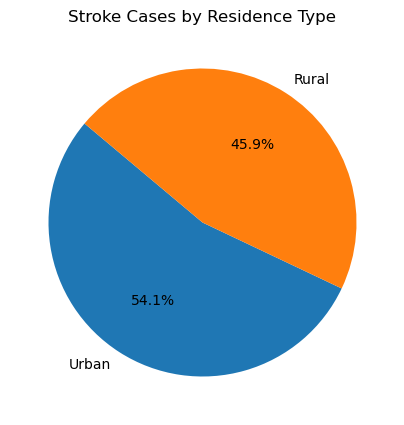

In [23]:
stroke_by_residence = df_clean[df_clean['stroke']==1]['Residence_type'].value_counts()

plt.figure(figsize=(5,5))
plt.pie(stroke_by_residence, labels=stroke_by_residence.index, autopct='%1.1f%%', startangle=140)
plt.title('Stroke Cases by Residence Type')
plt.show()

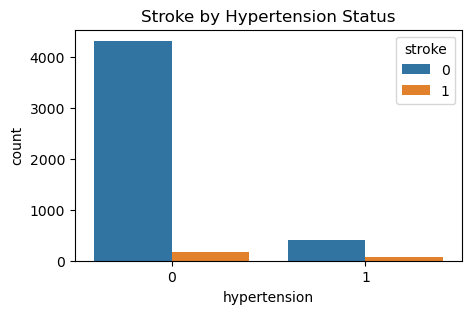

In [24]:
plt.figure(figsize=(5,3))
sns.countplot(x='hypertension', hue='stroke', data=df_clean)
plt.title('Stroke by Hypertension Status')
plt.show()

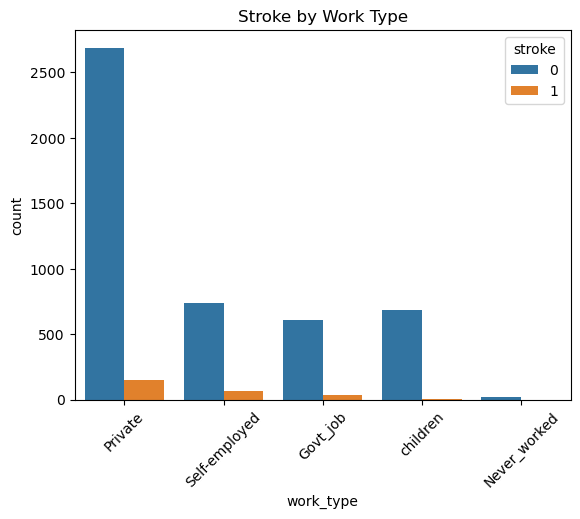

In [25]:
sns.countplot(x='work_type', hue='stroke', data=df_clean)
plt.title('Stroke by Work Type')
plt.xticks(rotation=45)  
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_24216\918854576.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['age_group'] = pd.cut(df_clean['age'], bins=[0, 20, 40, 60, 80, 100],
C:\Users\USER\AppData\Local\Temp\ipykernel_24216\918854576.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_stroke = df_clean.groupby('age_group')['stroke'].mean().reset_index()


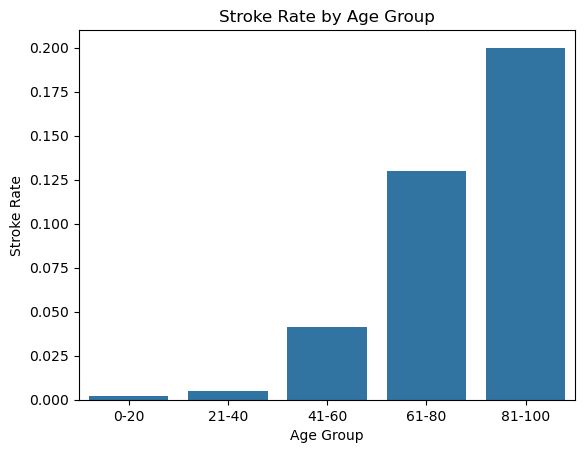

In [26]:
df_clean['age_group'] = pd.cut(df_clean['age'], bins=[0, 20, 40, 60, 80, 100], 
                                 labels=['0-20', '21-40', '41-60', '61-80', '81-100'])

age_group_stroke = df_clean.groupby('age_group')['stroke'].mean().reset_index()

sns.barplot(x='age_group', y='stroke', data=age_group_stroke)
plt.title('Stroke Rate by Age Group')
plt.ylabel('Stroke Rate')
plt.xlabel('Age Group')
plt.show()

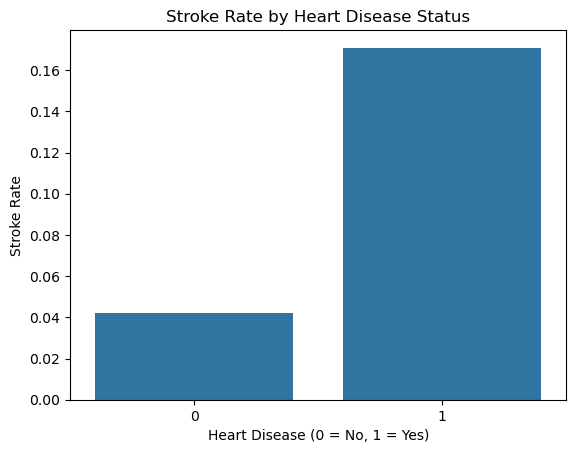

In [27]:
heart_stroke_rate = df_clean.groupby('heart_disease')['stroke'].mean().reset_index()

sns.barplot(x='heart_disease', y='stroke', data=heart_stroke_rate)
plt.title('Stroke Rate by Heart Disease Status')
plt.xlabel('Heart Disease (0 = No, 1 = Yes)')
plt.ylabel('Stroke Rate')
plt.show()

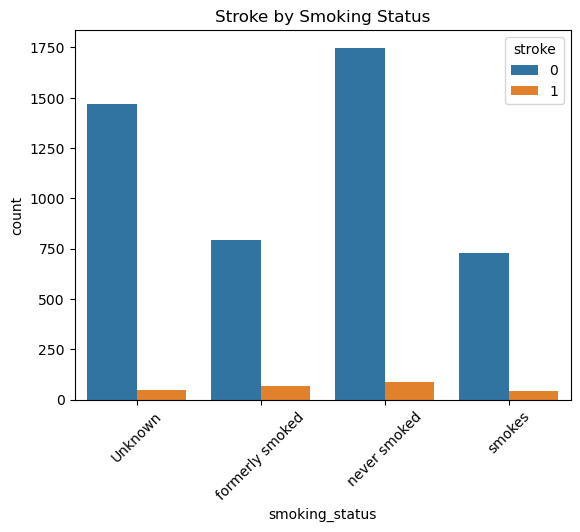

In [28]:
sns.countplot(x='smoking_status', hue='stroke', data=df_clean)
plt.title('Stroke by Smoking Status')
plt.xticks(rotation=45)
plt.show()

In [29]:
married_df = df_clean[df_clean['ever_married'] == 'Yes']

married_with_disease = married_df[(married_df['hypertension'] == 1) | (married_df['heart_disease'] == 1)]
male_married_disease = married_with_disease[married_with_disease['gender'] == 'Male'].shape[0]
female_married_disease = married_with_disease[married_with_disease['gender'] == 'Female'].shape[0]

total_married_disease = married_with_disease.shape[0]

male_ratio = male_married_disease / total_married_disease * 100
female_ratio = female_married_disease / total_married_disease * 100

print(f'Percentage of infected married men: {male_ratio:.2f}%')
print(f'Percentage of infected married women: {female_ratio:.2f}%')

Percentage of infected married men: 50.65%
Percentage of infected married women: 49.35%


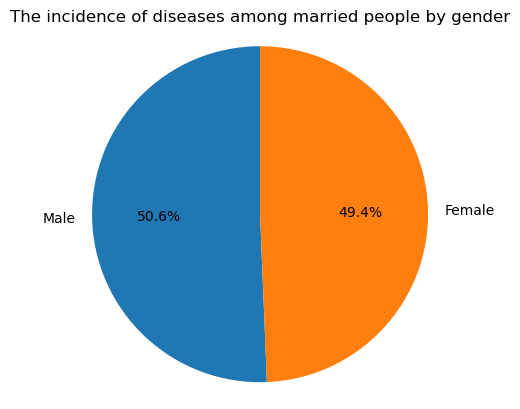

In [30]:
labels = ['Male', 'Female']
sizes = [male_ratio, female_ratio]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('The incidence of diseases among married people by gender')
plt.axis('equal') 
plt.show()

### Correlation Heatmap

This heatmap visualizes the correlation between key numerical features in the dataset

What it shows:  
The color intensity indicates the strength and direction of the correlation:
- Red tones indicate a strong positive correlation.
- Blue tones indicate a strong negative correlation.
- Values close to 0 suggest little to no linear relationship.

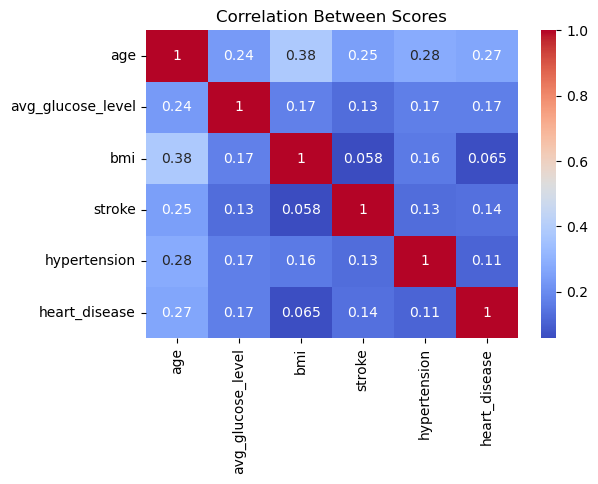

In [32]:
plt.figure(figsize=(6, 4))
sns.heatmap(df_clean[['age', 'avg_glucose_level', 'bmi','stroke','hypertension','heart_disease' ]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Between Scores")
plt.show()

### 🔍 Data Preparation and Preprocessing Details

- Target Variable (`y`) and Features (`X`):  
  We separate the dataset into input features and the target variable stroke.

- Encoding Categorical Variables:  
  pd.get_dummies() is used to convert categorical columns into numerical format using one-hot encoding.  
  drop_first=True avoids the dummy variable trap by removing the first category.

- Train-Test Split:
  - The data is split into 80% training and 20% testing sets.
  - stratify=y ensures that both training and test sets have the same class distribution as the original dataset.

- Feature Scaling:
  - Standardization is applied using StandardScaler.
  - It transforms the features to have zero mean and unit variance.
  - This is essential for many machine learning algorithms that are sensitive to feature scales, such as Logistic Regression

In [34]:
df_clean.columns = [str(col) for col in df_clean.columns]

X = df_clean.drop('stroke', axis=1)
y = df_clean['stroke']

X_encoded = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_resampled))

Before SMOTE: Counter({0: 3790, 1: 197})
After SMOTE: Counter({0: 3790, 1: 3790})


## Model Training and Evaluation

After preprocessing and balancing the data with SMOTE, we trained three different classification models to predict stroke occurrence:

### Models Used:

- Logistic Regression  
  A linear model commonly used for binary classification. It's simple, interpretable, and works best with linearly separable data.

- Random Forest Classifier  
  An ensemble method that builds multiple decision trees and combines their outputs to improve accuracy and reduce overfitting.

- XGBoost (Extreme Gradient Boosting)  
  A powerful and efficient gradient boosting algorithm that builds trees sequentially, optimizing for errors from previous trees. Known for its performance in structured/tabular data.

---

### Evaluation Metrics

Each model was evaluated on the test set using:

- Accuracy: Proportion of total correct predictions.
- Precision: Correct positive predictions out of all predicted positives.
- Recall: Correct positive predictions out of all actual positives.
- F1 Score: Harmonic mean of precision and recall, useful when dealing with imbalanced datasets.

---

### Summary

- All models were trained on scaled and SMOTE-resampled training data.
- Evaluation shows how well each model performs, especially in detecting the minority class (stroke cases).
- Based on the results, the best-performing model can be selected based on the highest F1 Score or Recall, depending on business/medical priority.

>  In medical scenarios like stroke prediction, Recall is often more important than Precision — we want to catch as many real stroke cases as possible, even if that means a few false positives.

In [37]:
#models
#1_logistic
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_resampled, y_resampled)

y_log_pred = log_model.predict(X_test_scaled)

print(" Logistic Regression:")
print(classification_report(y_test, y_log_pred))
print("Accuracy:", accuracy_score(y_test, y_log_pred))

 Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      0.72      0.83       948
           1       0.14      0.86      0.24        49

    accuracy                           0.73       997
   macro avg       0.56      0.79      0.53       997
weighted avg       0.95      0.73      0.80       997

Accuracy: 0.7261785356068204


In [38]:
#models
#2_random
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_resampled, y_resampled)

y_rf_pred = rf_model.predict(X_test_scaled)

print(" Random Forest:")
print(classification_report(y_test, y_rf_pred))
print("Accuracy:", accuracy_score(y_test, y_rf_pred))

 Random Forest:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       948
           1       0.16      0.10      0.12        49

    accuracy                           0.93       997
   macro avg       0.56      0.54      0.54       997
weighted avg       0.92      0.93      0.92       997

Accuracy: 0.9297893681043129


In [39]:
#models
#3_XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_resampled, y_resampled)

y_xgb_pred = xgb_model.predict(X_test_scaled)

print(" XGBoost:")
print(classification_report(y_test, y_xgb_pred))
print("Accuracy:", accuracy_score(y_test, y_xgb_pred))

C:\Users\USER\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:41:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 XGBoost:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       948
           1       0.14      0.10      0.12        49

    accuracy                           0.92       997
   macro avg       0.55      0.53      0.54       997
weighted avg       0.91      0.92      0.92       997

Accuracy: 0.9247743229689067


In [40]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Accuracy": [
        accuracy_score(y_test, y_log_pred),
        accuracy_score(y_test, y_rf_pred),
        accuracy_score(y_test, y_xgb_pred)
    ],
    "Precision": [
        precision_score(y_test, y_log_pred),
        precision_score(y_test, y_rf_pred),
        precision_score(y_test, y_xgb_pred)
    ],
    "Recall": [
        recall_score(y_test, y_log_pred),
        recall_score(y_test, y_rf_pred),
        recall_score(y_test, y_xgb_pred)
    ],
    "F1-Score": [
        f1_score(y_test, y_log_pred),
        f1_score(y_test, y_rf_pred),
        f1_score(y_test, y_xgb_pred)
    ]
})

print("Model Comparison:")
print(results.sort_values(by='F1-Score', ascending=False))

Model Comparison:
                 Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression  0.726179   0.136364  0.857143  0.235294
1        Random Forest  0.929789   0.161290  0.102041  0.125000
2              XGBoost  0.924774   0.138889  0.102041  0.117647


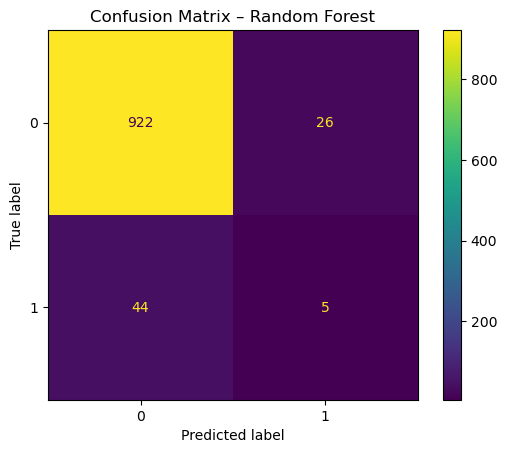

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = rf_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix – Random Forest")
plt.show()

In [ ]:
import joblib
joblib.dump(log_model, r"D:\DEPI\stroke_log_model.pkl")
joblib.dump(scaler, r"D:DEPI\scaler.pkl")
joblib.dump(X_encoded.columns.tolist(), r"D:\DEPI\feature_order.pkl")




['D:\\Khaled\\Yassmin DEPI Final project\\DEPI\\feature_order.pkl']